# ***IMPORT LIBARY***

In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import cv2
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import joblib

from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from torch.utils.data import Dataset,DataLoader, random_split
from sklearn.model_selection import train_test_split
from datetime import datetime
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings 
warnings.filterwarnings('ignore')

In [14]:


data_root_path = '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023'

dir_train = []

for dir in os.listdir(data_root_path):
    dir_train.append(os.path.join(data_root_path,dir))

dir_train = sorted(dir_train)



In [15]:

dir_train

['/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-07',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-08',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-09',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-10',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-11',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-12',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-13',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-14',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-15',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-datas

In [16]:
def parse_filename(filename):
    base = os.path.basename(filename)
    name = base.split('.jpg')[0] 
    time_str, radiation = name.split('_')
    dt = datetime.strptime(time_str, '%Y-%m-%d-%H-%M-%S')
    return dt, float(radiation)

data = []
for dir in dir_train:
    for file in os.listdir(dir):
        if file.endswith('.jpg'):
            dt, radiation = parse_filename(file)
            data.append({'datetime': dt, 'radiation': radiation, 'filename':os.path.join(dir,file)})


df = pd.DataFrame(data).sort_values('datetime')

In [17]:
len(df)

68708

In [18]:
df.head()

,datetime,radiation,filename
785,2023-09-07 05:00:06,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
4723,2023-09-07 05:00:16,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
5662,2023-09-07 05:00:26,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
1268,2023-09-07 05:00:36,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
1202,2023-09-07 05:00:46,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...


In [19]:
df.isnull().sum()

datetime     0
radiation    0
filename     0
dtype: int64

In [20]:
start = '2023-09-07 05:00:06'
end = '2023-09-18 19:57:53'
df_filtered = df[(df['datetime'] >= start) & (df['datetime'] <= end)]

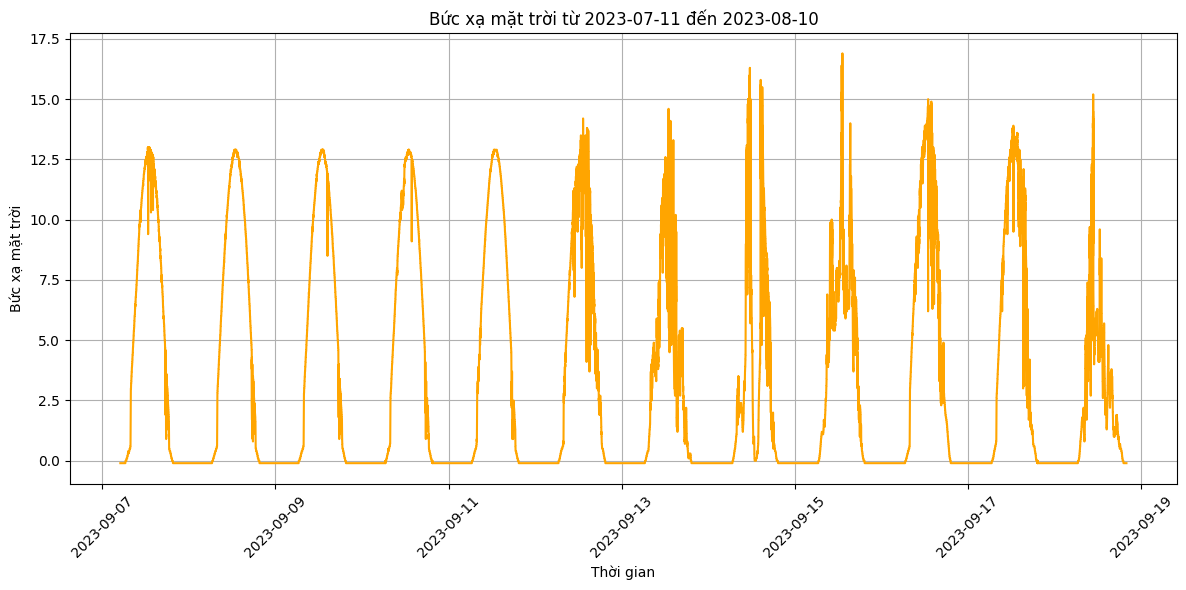

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['datetime'], df_filtered['radiation'],color = 'orange')
plt.title('Bức xạ mặt trời từ 2023-07-11 đến 2023-08-10')
plt.xlabel('Thời gian')
plt.ylabel('Bức xạ mặt trời')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
scaler = MinMaxScaler()
df['radiation_norm'] = scaler.fit_transform(df[['radiation']])
# Trong dataset bạn thay target = radiation_norm


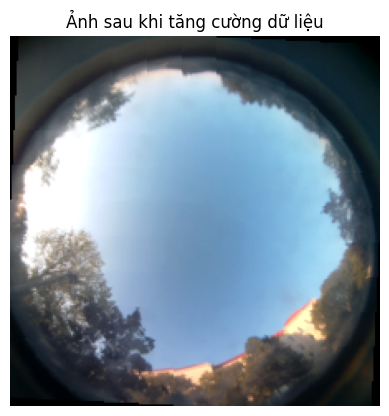

In [24]:
import random
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


idx_data = random.randint(1,2000)
img_path = df['filename'][idx_data]
img = Image.open(img_path).convert('RGB')


augmented_img = image_transform(img)


augmented_img = denormalize(augmented_img.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

np_img = augmented_img.permute(1, 2, 0).numpy()
plt.imshow(np.clip(np_img, 0, 1))
plt.title("Ảnh sau khi tăng cường dữ liệu")
plt.axis("off")
plt.show()

In [25]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
resnet = models.resnet50(pretrained=True)

modules = list(resnet.children())[:-2] 
cnn_backbone = nn.Sequential(*modules, nn.AdaptiveAvgPool2d((1, 1))) 

feature_extractor = nn.Sequential(
    cnn_backbone,
    nn.Flatten(),              # (B, 2048)
    nn.Linear(2048, 512)       # → (B, 512)
).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


In [26]:
def feature_extraction(filenames, feature_extractor):
    feature_extractor.eval()
    image_features = []

    for img_path in tqdm(filenames):
        img = Image.open(img_path).convert('RGB')
        img_tensor = image_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            feat = feature_extractor(img_tensor)  # (1, 512)
            feat = feat.squeeze(0).cpu()          # (512,)
            image_features.append(feat)

    return image_features

image_features = feature_extraction(df['filename'], feature_extractor)
len(image_features)

100%|██████████| 68708/68708 [30:29<00:00, 37.55it/s]


68708

In [27]:
# resnet = models.resnet18(pretrained=True)
# resnet.fc = torch.nn.Identity()  # bỏ fully-connected cuối
# resnet = resnet.to(device)
# resnet.eval()
# feature_cache_path = "resnet18_features.pt"
# # === Transform giống như training ===
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])


# # === Hàm trích feature ===
# def extract_features(df):
#     feature_dict = {}
#     with torch.no_grad():
#         for path in tqdm(df['filename'].unique(), desc="Extracting features"):
#             try:
#                 img = Image.open(path).convert("RGB")
#                 img_tensor = transform(img).unsqueeze(0).to(device)  # (1, 3, 224, 224)
#                 feature = resnet(img_tensor).squeeze(0).cpu()  # (512,)
#                 feature_dict[path] = feature
#             except Exception as e:
#                 print(f"Error with {path}: {e}")
#     return feature_dict

# # === Truyền df và tạo feature cache ===
# feature_dict = extract_features(df)
# torch.save(feature_dict, feature_cache_path)
# print(f"Saved features to: {feature_cache_path}")

In [28]:

# class CachedFeatureDataset(Dataset):
#     def __init__(self, df, feature_cache_path='resnet18_features.pt', seq_len=60, target_offset=30,stride=10):
#         self.df = df.reset_index(drop=True)
#         self.seq_len = seq_len
#         self.target_offset = target_offset

#         # Load toàn bộ cache đặc trưng ảnh (dict: {filename: tensor})
#         self.feature_dict = torch.load(feature_cache_path)
#         self.samples = []

#         max_index = len(df) - (seq_len + target_offset)
#         for i in range(max_index):
#             fnames = df['filename'].iloc[i:i + seq_len].values
#             radiation_seq = df['radiation'].iloc[i:i + seq_len].values
#             target = df['radiation'].iloc[i + seq_len + target_offset - 1]
#             self.samples.append((fnames, radiation_seq, target))

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         fnames, rad_seq, target = self.samples[idx]
#         feature_seq = []

#         for path in fnames:
#             if path not in self.feature_dict:
#                 raise KeyError(f"[!] Missing feature for image: {path}")
#             feature_seq.append(self.feature_dict[path])  # tensor shape (512,)

#         image_feats = torch.stack(feature_seq)            # (seq_len, 512)
#         radiation_seq = torch.tensor(rad_seq).float()     # (seq_len,)
#         target_tensor = torch.tensor(target).float()      # scalar

#         return image_feats, radiation_seq, target_tensor

In [29]:
class RadiationDataset(Dataset):
    def __init__(self, df, image_features, sequence_length=60, forecast_horizon=30, stride=10):
        self.df = df
        self.image_features = image_features
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon
        self.stride = stride

    def __len__(self):
        return (len(self.df) - self.sequence_length - self.forecast_horizon) // self.stride

    def __getitem__(self, idx):
        base_idx = idx * self.stride
        img_seq = []
        rad_seq = []

        for i in range(self.sequence_length):
            img_feat = self.image_features[base_idx + i]
            img_seq.append(img_feat)
            rad_seq.append(self.df.iloc[base_idx + i]['radiation'])

        img_seq = torch.stack(img_seq)
        rad_seq = torch.tensor(rad_seq, dtype=torch.float32).unsqueeze(-1)
        target = torch.tensor(self.df.iloc[base_idx + self.sequence_length + self.forecast_horizon - 1]['radiation'], dtype=torch.float32)

        return img_seq, rad_seq, target

In [30]:
sequence_length = 60
forecast_horizon = 30


split_time = int(0.8 * len(df))


train_df = df.iloc[:split_time].reset_index(drop=True)
val_df = df.iloc[split_time:].reset_index(drop=True)


train_image_features = image_features[:split_time]
val_image_features = image_features[split_time:]

train_dataset = RadiationDataset(
    df=train_df,
    image_features=train_image_features,
    sequence_length=sequence_length,
    forecast_horizon=forecast_horizon
)

val_dataset = RadiationDataset(
    df=val_df,
    image_features=val_image_features,
    sequence_length=sequence_length,
    forecast_horizon=forecast_horizon
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [31]:
# train_df, val_df = train_test_split(df, test_size=0.2, shuffle=False)

# train_ds = CachedFeatureDataset(train_df, feature_cache_path='resnet18_features.pt')
# val_ds = CachedFeatureDataset(val_df, feature_cache_path='resnet18_features.pt')

# train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)

In [32]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500, dropout=0.3):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return self.dropout(x)

class TimeSformer(nn.Module):
    def __init__(self, img_feat_dim=512, rad_feat_dim=1, d_model=128, nhead=4, num_layers=2, dropout=0.3):
        super().__init__()

        self.img_proj = nn.Linear(img_feat_dim, d_model)
        self.img_posenc = PositionalEncoding(d_model, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=512,
                                                   dropout=dropout, batch_first=True, activation='gelu')
        self.img_transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.rad_proj = nn.Linear(rad_feat_dim, d_model)
        self.rad_posenc = PositionalEncoding(d_model, dropout=dropout)
        self.rad_transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Sequential(
            nn.LayerNorm(d_model * 2),
            nn.Linear(d_model * 2, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, img_feats, rad_seq):
        if rad_seq.ndim == 2:
            rad_seq = rad_seq.unsqueeze(-1)

        x_img = self.img_proj(img_feats)
        x_img = self.img_posenc(x_img)
        x_img = self.img_transformer(x_img)
        img_repr = x_img.mean(dim=1)

        x_rad = self.rad_proj(rad_seq)
        x_rad = self.rad_posenc(x_rad)
        x_rad = self.rad_transformer(x_rad)
        rad_repr = x_rad.mean(dim=1)

        combined = torch.cat([img_repr, rad_repr], dim=-1)
        output = self.fc(combined).squeeze(-1)
        return output


In [33]:
import torch.nn as nn
num_epochs = 20
criterion = nn.MSELoss()
from torch.optim.lr_scheduler import CosineAnnealingLR
model = TimeSformer(dropout=0.3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)



In [34]:
train_losses, val_losses = [], []
val_preds_all, val_targets_all = [], []
for epoch in range(1, 21):
    model.train()
    train_loss = 0.0
    for img_feat, rad_seq, target in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        img_feat, rad_seq, target = img_feat.to(device), rad_seq.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(img_feat, rad_seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * img_feat.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for img_feat, rad_seq, target in tqdm(val_loader, desc="Validating"):
            img_feat, rad_seq, target = img_feat.to(device), rad_seq.to(device), target.to(device)
            output = model(img_feat, rad_seq)
            loss = criterion(output, target)
            val_loss += loss.item() * img_feat.size(0)
            val_preds.append(output.cpu())
            val_targets.append(target.cpu())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    val_preds_all.append(torch.cat(val_preds).numpy())
    val_targets_all.append(torch.cat(val_targets).numpy())

    # Cập nhật Cosine Scheduler
    scheduler.step()

    print(f"Epoch {epoch} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Validating: 100%|██████████| 171/171 [00:03<00:00, 49.15it/s]


Epoch 1 - Train Loss: 4.4902, Val Loss: 2.0822


Validating: 100%|██████████| 171/171 [00:03<00:00, 47.08it/s]


Epoch 2 - Train Loss: 1.5248, Val Loss: 1.4951


Validating: 100%|██████████| 171/171 [00:03<00:00, 50.97it/s]


Epoch 3 - Train Loss: 1.5239, Val Loss: 1.4253


Validating: 100%|██████████| 171/171 [00:03<00:00, 51.37it/s]


Epoch 4 - Train Loss: 1.4023, Val Loss: 1.5970


Validating: 100%|██████████| 171/171 [00:03<00:00, 44.92it/s]


Epoch 5 - Train Loss: 1.3584, Val Loss: 1.6842


Validating: 100%|██████████| 171/171 [00:03<00:00, 50.09it/s]


Epoch 6 - Train Loss: 1.3138, Val Loss: 1.6380


Validating: 100%|██████████| 171/171 [00:03<00:00, 48.98it/s]


Epoch 7 - Train Loss: 1.3081, Val Loss: 1.2919


Validating: 100%|██████████| 171/171 [00:03<00:00, 50.66it/s]


Epoch 8 - Train Loss: 1.2685, Val Loss: 1.2591


Validating: 100%|██████████| 171/171 [00:03<00:00, 48.50it/s]


Epoch 9 - Train Loss: 1.2596, Val Loss: 1.2779


Validating: 100%|██████████| 171/171 [00:03<00:00, 50.79it/s]


Epoch 10 - Train Loss: 1.2099, Val Loss: 1.3663


Validating: 100%|██████████| 171/171 [00:03<00:00, 49.55it/s]


Epoch 11 - Train Loss: 1.2045, Val Loss: 1.2365


Validating: 100%|██████████| 171/171 [00:03<00:00, 51.64it/s]


Epoch 12 - Train Loss: 1.2019, Val Loss: 1.2672


Validating: 100%|██████████| 171/171 [00:03<00:00, 44.97it/s]


Epoch 13 - Train Loss: 1.1729, Val Loss: 1.2726


Validating: 100%|██████████| 171/171 [00:03<00:00, 51.54it/s]


Epoch 14 - Train Loss: 1.1287, Val Loss: 1.2641


Validating: 100%|██████████| 171/171 [00:03<00:00, 51.64it/s]


Epoch 15 - Train Loss: 1.1428, Val Loss: 1.2017


Validating: 100%|██████████| 171/171 [00:03<00:00, 51.31it/s]


Epoch 16 - Train Loss: 1.1250, Val Loss: 1.2666


Validating: 100%|██████████| 171/171 [00:03<00:00, 50.81it/s]


Epoch 17 - Train Loss: 1.1276, Val Loss: 1.2246


Validating: 100%|██████████| 171/171 [00:03<00:00, 50.93it/s]


Epoch 18 - Train Loss: 1.0824, Val Loss: 1.2456


Validating: 100%|██████████| 171/171 [00:03<00:00, 49.94it/s]


Epoch 19 - Train Loss: 1.1004, Val Loss: 1.2144


Validating: 100%|██████████| 171/171 [00:03<00:00, 50.26it/s]

Epoch 20 - Train Loss: 1.1064, Val Loss: 1.2088


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = val_preds_all[-1]
y_true = val_targets_all[-1]


mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

r2 = r2_score(y_true, y_pred)
print(f"R-squared (R²): {r2:.4f}")


Mean Absolute Error (MAE): 0.6332
Root Mean Squared Error (RMSE): 1.0994
R-squared (R²): 0.9380


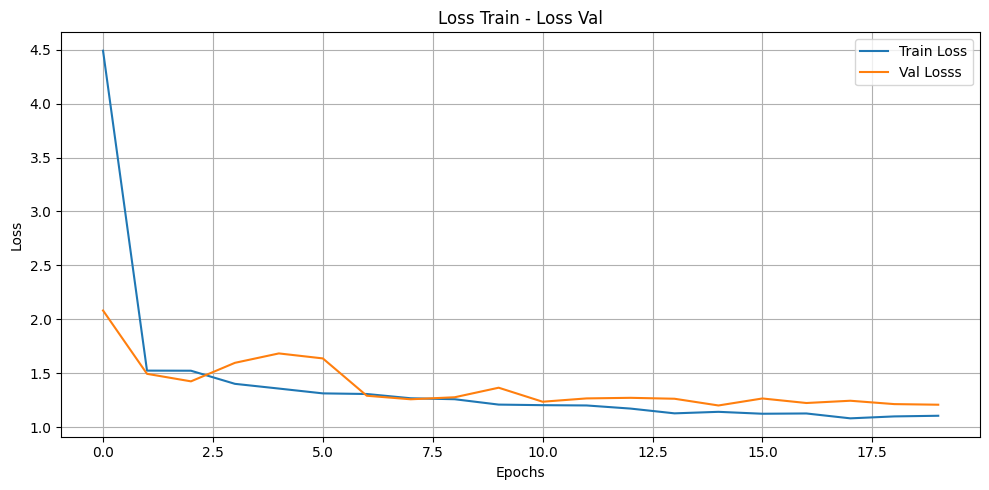

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Losss')
plt.title('Loss Train - Loss Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

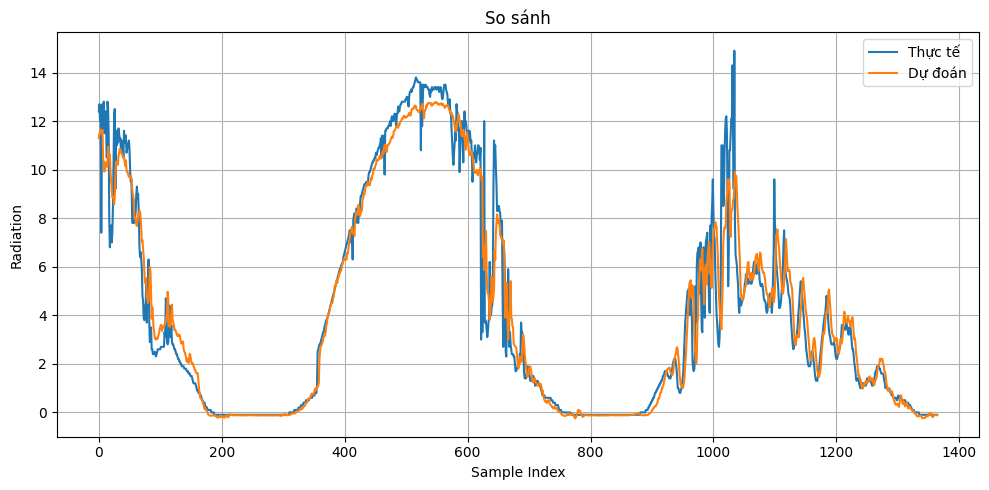

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(val_targets_all[-1], label='Thực tế')
plt.plot(val_preds_all[-1], label='Dự đoán')
plt.title('So sánh')
plt.xlabel('Sample Index')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
